# Data Cleaning and Feature Selection

## Imports

In [22]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

## Data Cleaning

### 1. Outliers

Standard deviation method

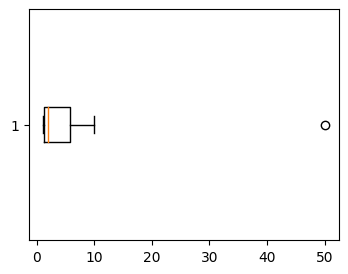

Mean =  5.944444444444445 
Std =  11.007432954459162
Outliers:
 [50]


In [23]:
data = [1, 2, 5, 6, 3, 1, 1, 7, 2, 2, 2, 3, 1, 1, 2, 8, 10, 50]

# construct boxplot to see if there are outliers:
plt.figure(figsize = (4,3))
plt.boxplot(data, vert = False)
plt.show()

# get the mean and standard deviation of the data:
mean = np.mean(data)
std = np.std(data)
print("Mean = ", mean, "\nStd = ", std)

# define threshold of z score and get the outliers
threshold = 3
outliers = []
for i in data:
    z = (i - mean)/ std
    if z > threshold:
        outliers.append(i)

print("Outliers:\n", outliers)


Interquartile range method

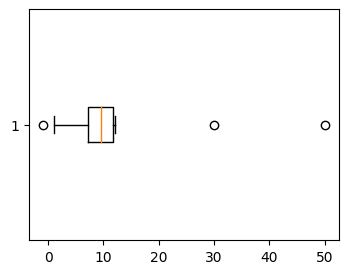

Quartile values using numpy:
Q1 =  7.25 
Q3 =  11.75
Quartile values using pandas:
Q1_pd =  7.25 
Q3_pd =  11.75

Boundaries:
lower =  0.5 
upper =  18.5

Outliers:  [-1 30 50]


In [24]:
# define data
data = np.array([-1, 1, 7, 8, 9, 10, 11, 12, 30, 50])

# boxplot
plt.figure(figsize = (4,3))
plt.boxplot(data, vert = False)
plt.show()

# get quartile values using numpy
Q1, Q3 = np.percentile(data, (25, 75))
print("Quartile values using numpy:")
print("Q1 = ", Q1, "\nQ3 = ", Q3)

# get quartile values using pandas
import pandas as pd
data_df = pd.DataFrame(data)
Q1_pd = data_df.quantile(0.25)
Q3_pd = data_df.quantile(0.75)
print("Quartile values using pandas:")
print("Q1_pd = ", Q1_pd[0], "\nQ3_pd = ", Q3_pd[0])

# calculate IQR and boundry values:
IQR = Q3 - Q1
lower_bound = Q1 - (1.5*IQR)
upper_bound = Q3 + (1.5*IQR)
print("\nBoundaries:")
print("lower = ", lower_bound, "\nupper = ", upper_bound)

# create conditions to isolate the outliers
outliers = data[(data < lower_bound)| (data> upper_bound)]
print("\nOutliers: ", outliers)

Automatic outlier detection

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_iris

# iris info
df,y = load_iris(return_X_y=True, as_frame=True)
data_info = load_iris()
features = data_info["feature_names"]
print(features)

# create a model and fit it to the data
model = IsolationForest(n_estimators=50, 
                        max_samples='auto', 
                        contamination=float(0.1),
                        max_features=1, 
                        verbose = 1)

model.fit(df[['sepal length (cm)']])

# add other columns scores and anomaly
df["scores"] = model.decision_function(df[["sepal length (cm)"]])
df["anomaly"] = model.predict(df[["sepal length (cm)"]])
#print(df.head(5))

# get the data points where anomaly = -1:
anomalies = df.loc[df["anomaly"]==-1]
print("Anomalies: \n", anomalies[:3])
outliers_count = len(anomalies)
print("\nOutlier Count: ", outliers_count)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Anomalies: 
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
8                 4.4               2.9                1.4               0.2   
13                4.3               3.0                1.1               0.1   
38                4.4               3.0                1.3               0.2   

      scores  anomaly  
8  -0.016901       -1  
13 -0.115332       -1  
38 -0.016901       -1  

Outlier Count:  15


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\Users\kruth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


### 2. Missing Values

Statistical Imputation

In [28]:
df1 = df.copy()
for i in range(6):
    df1.loc[0:i,'sepal length (cm)'] = np.NaN

for i in range(2,6):
    df1.loc[2:i,'petal length (cm)'] = np.NaN

df1.head(8)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),scores,anomaly
0,NaN,3.5,1.4,0.2,0.130954,1
1,NaN,3.0,1.4,0.2,0.080328,1
2,NaN,3.2,NaN,0.2,0.011245,1
3,NaN,3.1,NaN,0.2,0.030392,1
4,NaN,3.6,NaN,0.2,0.129123,1
5,NaN,3.9,NaN,0.4,0.099905,1
6,4.6,3.4,1.4,0.3,0.030392,1
7,5.0,3.4,1.5,0.2,0.129123,1


Iterative Imputer:

Initialization: Initially, the missing values in the dataset are filled with some initial values. These initial values can be mean, median, or any other sensible estimate of the missing values.

Iteration: The imputation process is carried out iteratively. In each iteration, one feature with missing values is selected as the target feature, while all other features (including those with missing values) are treated as predictor features.

Model Building: A predictive model, such as a linear regression model or a Bayesian ridge regression model, is trained using the predictor features to predict the missing values in the target feature. The model estimates the missing values based on the available data and the relationships between features.

Update Missing Values: After the model is trained, it is used to predict and update the missing values in the target feature.

Repeat: Steps 2 to 4 are repeated for each feature with missing values in the dataset. The order in which the features are imputed can be predetermined or chosen randomly.

Convergence: The imputation process continues for a specified number of iterations or until a convergence criterion is met. The convergence criterion is often based on the change in imputed values between iterations.

Final Imputed Dataset: Once the specified number of iterations is completed or convergence is achieved, the dataset will have all missing values imputed based on the relationships between features. The final imputed dataset is then used for further analysis or modeling.

The Iterative Imputer is effective in capturing complex relationships between features and tends to provide more accurate imputations compared to simpler methods like mean or median imputation. It takes into account the interdependencies between variables and adjusts missing values accordingly. However, it can be computationally intensive, especially for large datasets or datasets with a large number of features.

It's important to note that the choice of the predictive model used in the imputation process can vary based on the nature of the data and the problem at hand. Additionally, the number of iterations and the convergence criteria should be set carefully to balance computational resources and imputation accuracy.

In [40]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

s = SimpleImputer( missing_values=np.NaN, strategy="mean")
i = IterativeImputer(imputation_order='ascending')
k = KNNImputer(n_neighbors=3)

s.fit(df1)
i.fit(df1)
k.fit(df1)

df_si = pd.DataFrame(s.transform(df1), columns=df1.columns)
df_ii = pd.DataFrame(i.transform(df1), columns=df1.columns)
df_ki = pd.DataFrame(k.transform(df1), columns=df1.columns)

In [41]:
df.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),scores,anomaly
0,5.1,3.5,1.4,0.2,0.130954,1
1,4.9,3.0,1.4,0.2,0.080328,1
2,4.7,3.2,1.3,0.2,0.011245,1
3,4.6,3.1,1.5,0.2,0.030392,1
4,5.0,3.6,1.4,0.2,0.129123,1


In [42]:
df_si.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),scores,anomaly
0,5.880556,3.5,1.400000,0.2,0.130954,1.0
1,5.880556,3.0,1.400000,0.2,0.080328,1.0
2,5.880556,3.2,3.820548,0.2,0.011245,1.0
3,5.880556,3.1,3.820548,0.2,0.030392,1.0
4,5.880556,3.6,3.820548,0.2,0.129123,1.0


In [43]:
df_ii.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),scores,anomaly
0,5.000975,3.5,1.400000,0.2,0.130954,1.0
1,4.688552,3.0,1.400000,0.2,0.080328,1.0
2,4.940928,3.2,1.606112,0.2,0.011245,1.0
3,4.895034,3.1,1.628968,0.2,0.030392,1.0
4,5.040649,3.6,1.365820,0.2,0.129123,1.0


In [45]:
df_ki.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),scores,anomaly
0,5.266667,3.5,1.400000,0.2,0.130954,1.0
1,4.833333,3.0,1.400000,0.2,0.080328,1.0
2,4.700000,3.2,1.533333,0.2,0.011245,1.0
3,4.766667,3.1,1.500000,0.2,0.030392,1.0
4,5.166667,3.6,1.233333,0.2,0.129123,1.0
5,5.200000,3.9,1.566667,0.4,0.099905,1.0
6,4.600000,3.4,1.400000,0.3,0.030392,1.0
